In [1]:
# Shiqi Jiang ,3/6/2022

## Data normalization, weighted fitting with more sigmoid

In [2]:
# 9 Species: AT, CE, DM, ...
# 8 Classes: ER, ERDD, GEO, GEOGD ...(each with ~500 data points)
# normalization is done on each species seperetaly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.special import erf
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import FormatStrFormatter

### normalization on AT only

In [2]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
data_locations = [r"D:\file\Research\P-value\data\AT"+c for c in classes]

In [3]:
def combine_data(data_location,classes):
    df_comb = pd.DataFrame()
    i = 0
    for protein in data_location:
        df = pd.read_csv(protein, header = None, sep = ' ')
        df['class'] = classes[i]
        df_comb = pd.concat([df, df_comb])
        i += 1
    return df_comb

In [4]:
df_comb = combine_data(data_locations,classes)
df_class = df_comb['class']
df_comb = df_comb.drop("class", axis = 1)
df_comb = pd.DataFrame(MinMaxScaler().fit_transform(df_comb))
df_comb['class'] = df_class.reset_index(drop = True)

In [5]:
def data(dataframe, class_name):
    return dataframe[dataframe['class']==class_name].drop("class",axis=1).to_numpy()

In [6]:
df_comb

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,class
0,0.119280,0.040492,0.058450,0.136129,0.003547,1.000000,7.582854e-03,6.688470e-03,0.003330,0.593265,...,5.522624e-01,0.000167,0.000354,0.004801,0.361071,0.000507,0.029150,0.000768,0.000255,Original
1,0.109779,0.034315,0.085867,0.246487,0.002246,0.086475,3.277164e-02,1.555581e-02,0.008997,0.799749,...,5.138442e-01,0.000264,0.009294,0.035106,0.081085,0.007446,0.019006,0.005419,0.000893,Sticky
2,0.103433,0.034762,0.088874,0.251821,0.002232,0.087226,3.376620e-02,1.641144e-02,0.009725,0.805912,...,5.316402e-01,0.000281,0.010060,0.037169,0.086458,0.008072,0.021025,0.005966,0.000977,Sticky
3,0.097718,0.035894,0.085879,0.251788,0.002546,0.086120,3.416294e-02,1.587028e-02,0.008426,0.795594,...,5.233801e-01,0.000290,0.009116,0.036344,0.080334,0.007392,0.019215,0.005143,0.000747,Sticky
4,0.094860,0.034294,0.087267,0.246125,0.002229,0.085835,3.336908e-02,1.624090e-02,0.009587,0.784560,...,5.179674e-01,0.000288,0.009873,0.036609,0.082901,0.008016,0.019810,0.005881,0.000989,Sticky
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3743,0.111895,0.002110,0.000046,0.004011,0.000004,0.000012,7.176735e-07,0.000000e+00,0.000000,0.004517,...,7.412617e-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ER
3744,0.114901,0.002137,0.000043,0.004081,0.000004,0.000006,7.581743e-07,3.545448e-08,0.000000,0.004624,...,2.223785e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ER
3745,0.139061,0.002265,0.000048,0.004332,0.000004,0.000016,8.002951e-07,0.000000e+00,0.000000,0.004951,...,1.853154e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ER
3746,0.115235,0.002141,0.000061,0.004081,0.000004,0.000017,8.764365e-07,0.000000e+00,0.000000,0.004618,...,4.447570e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,ER


### Weighted fitting

In [62]:
def logistic(x,x0, k):
    m = (1/ (1 + np.exp(-k*(x-x0))))      
    return m

def tanh(x, x0, k): # for log curve_fit
    m = (1+np.tanh(k*(x-x0)))/2
    return m

def arctan(x, x0, k):
    m = (2/np.pi)*np.arctan(k*(x-x0))
    return m

def GD(x, x0, k):
    m = (4/np.pi)*np.arctan(np.tanh(k*(x-x0)))
    return m

### 3.7 meeting. Try on weighted_combination of arctan GD
def arctan_GD(x,x0,k, w):
    m = w*GD(x,x0,k)+(1-w)*arctan(x,x0,k)

def ERF(x, x0, k):
    m = erf(k*(x-x0))
    return m

def algebra(x, x0, k):
    m = x/((1+abs(x)**k)**(1/k))
    return m

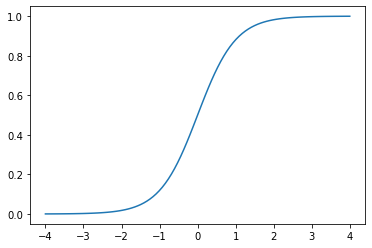

In [23]:
# tanh
x = np.linspace(-4,4,100)
f,ax = plt.subplots(1,1)
ax.plot(x,tanh(x,0,1))
plt.show()

In [9]:
# calculating empirical data's shortest(NN) distance 
# real data is high-dimensional data points
def data_distance(data):
    shortest_distance = [0]*len(data)
    for i in range(len(data)):
        x = np.delete(data,i,0)
        temp = (x-data[i])**2
        d = np.sqrt(np.sum(temp,axis=1))
        shortest_distance[i] = d.min()
    
    return np.array(shortest_distance)   # return an array of real data's NN distance

# plotting empirical data's NN hist
def plot_data_distance(D, title):
    """
    D: an array of real data' NN distance
    """
    f, ax = plt.subplots(1,1, figsize = (6,4))
    ax.hist(D,edgecolor='white',bins=50)   ## consider specifying <bins>
    ax.set_title(title)
    plt.show()
    return

# plot CDF of empirical NN
def plot_empirical_CDF(data, Density,title):
    '''
    return x,y data of CDF
    if density==True, y is percentage where y[-1]=1 
    '''
    f, ax = plt.subplots(1,1,figsize=(6,4))
    h = ax.hist(data,bins=len(data),density=Density,cumulative=True,histtype='stepfilled')    # bins set to equal to # of empirical data
    x = h[1][:-1]
    y = h[0]
    ax.plot(x,y,color='k', label='Empirical')
    ax.set_title(title)
    ax.legend()
    plt.show()
    return x,y

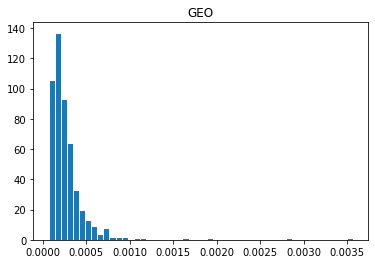

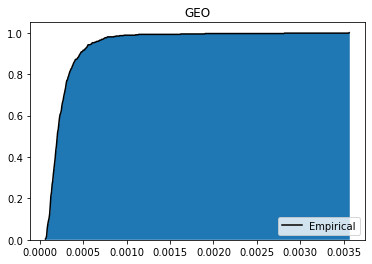

In [10]:
dd_GEO = data_distance(data(df_comb,'GEO'))
plot_data_distance(dd_GEO,'GEO')
x,y = plot_empirical_CDF(dd_GEO,True,'GEO')

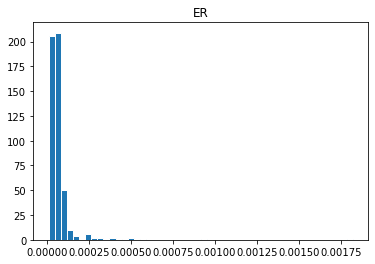

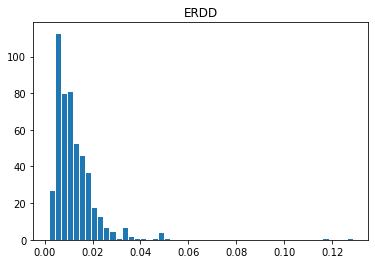

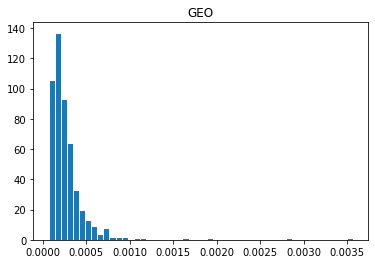

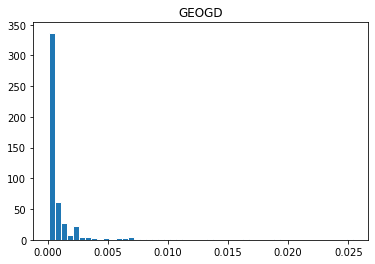

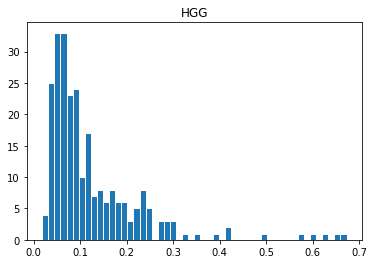

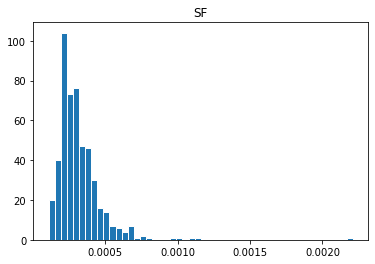

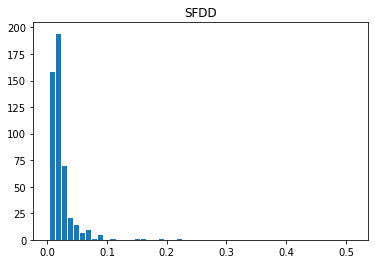

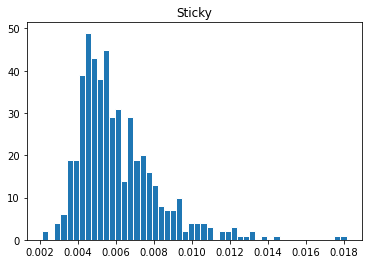

In [25]:
for c in classes[:-1]:
    dd = data_distance(data(df_comb,c))
    plot_data_distance(dd,c)

In [11]:
# curve_fit()
def auto_curve_fit(data_NN, x, y, x_scale_factor, func,s=None):
    '''
    data_NN: array empirical data_distance for calculating median
    x,y: from CDF
    s: sigma in curve_fit(), for weighting
    '''
    
    p0 = [np.median(data_NN)/x_scale_factor,1] # this is initial guess for sigmoid parameters

    #popt, pcov = curve_fit(f=func, xdata=x, ydata=y, p0=p0,method='lm', sigma=s)
    popt, pcov = curve_fit(f=func, xdata=x/x_scale_factor, ydata=y, p0=p0,method='lm', sigma=s)

    # parameters yielded by Curve_fit: x0, k
    print("curve_fit parameter values: ", popt)
    return popt

In [12]:
def sigmoid_preview(func,x,x_scale_factor,popt,name):
    y2 = func(x/x_scale_factor, *popt)
    plt.plot(x/x_scale_factor,y2)
    plt.title(name)
    plt.show()

In [13]:
def plot_pair(x, y, x_scale_factor, func, param, name, color):
    '''
    x,y: empirical_NN and probability value
    x_scale_factor: scaling factor observed to avoid func overflowing
    func: sigmoid function
    param: parameters generated by Curve_fit()
    '''
    f,ax = plt.subplots(1,1,figsize=(8,12))
    #y2 = func(x,*param)
    y2 = func(x/x_scale_factor, *param)
    
    ax.set_yscale('log')
    ax.tick_params(axis='y', which='minor')
    ax.yaxis.set_minor_formatter(FormatStrFormatter("%.5e"))
    ax.scatter(x,1-y, color=color,marker='.')
    ax.plot(x,1-y2, color='b', label=name)
    
    ax.legend(loc='upper left')
    plt.show()
    return 

curve_fit parameter values:  [0.66042763 0.28462009]


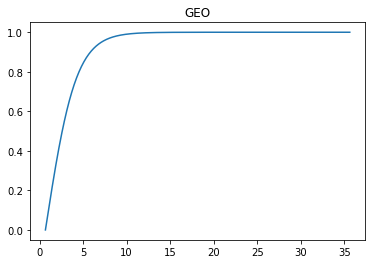

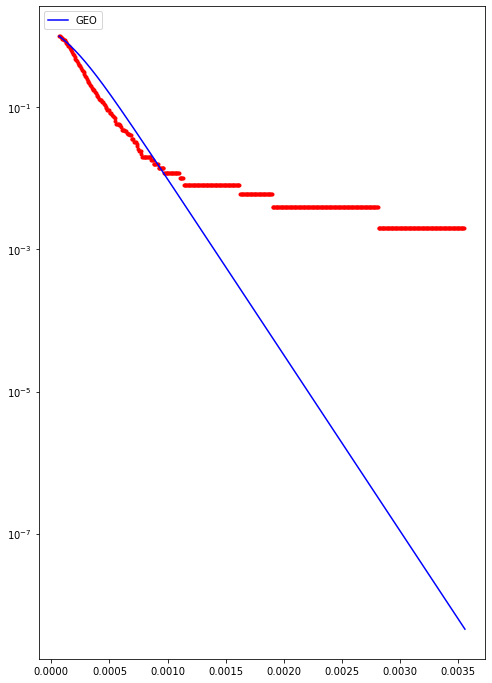

In [14]:
p1 = auto_curve_fit(dd_GEO, x,y,1e-4,tanh,y)
sigmoid_preview(tanh,x,1e-4,p1,'GEO')
plot_pair(x,y,1e-4,tanh,p1,'GEO','r')

### hand-weighting

In [15]:
origin = np.array([x,1-y])
print(origin.shape)
# taking one point from each tick > 1e-2
less = origin[:,origin[1]<=1e-2]
greater = origin[:,origin[1]>1e-2]
print(greater.shape)
print(less.shape)

bounds = list(range(100,10,-10))+list(range(10,0,-1))
for i in range(len(bounds)-1):
    upper = bounds[i]*1e-2
    lower = bounds[i+1]*1e-2
        
    inter_temp = greater[:,greater[1]<=upper]
    interval = inter_temp[:, inter_temp[1]>lower]
    print("interval length: ",interval.shape[1])
    
    if i == 0:
        new = interval[:,interval.shape[1]//2].reshape((2,1))
    
    else:
        new = np.hstack((new,interval[:,interval.shape[1]//2].reshape((2,1))))  # take mid point of that interval

print(new.shape)

(2, 499)
(2, 153)
(2, 346)
interval length:  6
interval length:  3
interval length:  4
interval length:  4
interval length:  3
interval length:  4
interval length:  7
interval length:  8
interval length:  19
interval length:  4
interval length:  3
interval length:  4
interval length:  1
interval length:  7
interval length:  12
interval length:  7
interval length:  17
interval length:  40
(2, 18)


(2, 364)


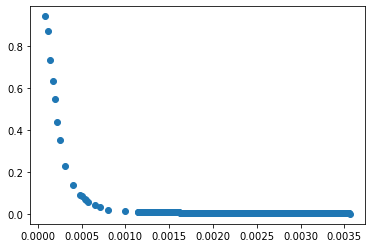

In [16]:
filtered_data = np.hstack((new,less))
print(filtered_data.shape)
f,ax = plt.subplots(1,1)
ax.scatter(filtered_data[0],filtered_data[1])
plt.show()

In [17]:
x2,y2 = filtered_data[0], 1-filtered_data[1]    # y2 is p-value in CDF i.e. increasing to 1
d = np.array([x2,y2]).T
sorted_d = d[np.argsort(d[:,0])].T
s_x2, s_y2 = sorted_d[0],sorted_d[1]

curve_fit parameter values:  [0.73695046 0.38226536]


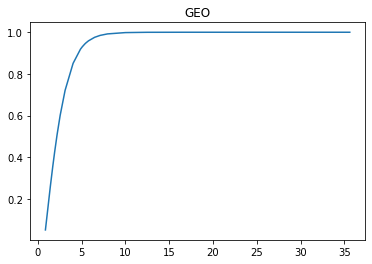

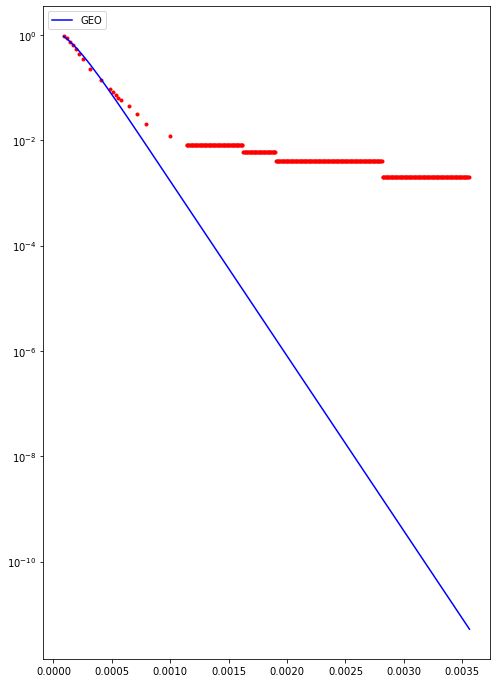

In [18]:
p2 = auto_curve_fit(dd_GEO, s_x2,s_y2,1e-4,tanh,s_y2)
sigmoid_preview(tanh,s_x2,1e-4,p2,'GEO')
plot_pair(s_x2,s_y2,1e-4,tanh,p2,'GEO','r')

In [ ]:
# For each AT: Empirical CDF + Sigmoid Preview + CDF-Sigmoid Pair
def cdf_sigmoid_pair(data_list,data_name,factor,colors,function,s=False):
    x_s = [0]*8
    y_s = [0]*8
    popt_s = [0]*8
    
    for i in range(len(data_list)):
        NN_i = data_distance(data_list[i])
        x_s[i],y_s[i] = plot_empirical_CDF(NN_i,True,data_name[i])
        y_s[i] = np.log10(y_s[i])
        sig = y_s[i] if s else None
        popt_s[i] = auto_curve_fit(NN_i, x_s[i], y_s[i], factor[i],function,s=sig)
        sigmoid_preview(function, x_s[i],factor[i],popt_s[i],data_name[i])
        plot_pair(x_s[i],y_s[i],factor[i],function,popt_s[i],data_name[i],colors[i]) 
    
    return x_s, y_s, popt_s

# All CDF-Sigmoid Pairs in one image.
def pair_in_one(data_name, factor, colors, function, x_s, y_s, popt_s):
    f,ax = plt.subplots(1,1,figsize=(20,10))
    ax.set_yscale('log')
    ax.set_xscale('log')
    for j in range(8):
        y2 = function(x_s[j]/factor[j],*popt_s[j])
        ax.scatter(x_s[j],1-y_s[j],color=colors[j],marker='.')
        ax.plot(x_s[j],1-y2, color=colors[j],label=data_name[j])
    ax.legend(loc='lower left')
    plt.show()

In [30]:
classes = ['ER', 'ERDD', 'GEO', 'GEOGD', 'HGG', 'SF', 'SFDD', 'Sticky','Original']
factors = [1e-5, 1e-2, 1e-4, 1e-3, 1e-2, 1e-4, 1e-2, 1e-3]
colors = ['g','r','c','m','y','k','brown']
functions = [logistic, tanh, arctan, GD, ERF, algebra]

In [59]:
def sigmoids_for_data_1y(data, name, factor, func_list, color_list):
    x,y = plot_empirical_CDF(data, True, name)
    f,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_title('1-y Sigmoids on '+name)
    ax.set_yscale('log')
    #ax.scatter(x,y, color='b')
    ax.scatter(x,1-y, color='b')
    for i in range(len(func_list)):
        p = auto_curve_fit(data,x,y,factor,func_list[i],y)
        y2 = func_list[i](x/factor, *p)
        ax.plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        #ax.plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax.legend(loc='lower left')
    plt.show()

In [60]:
def sigmoids_for_data_y(data, name, factor, func_list, color_list):
    x,y = plot_empirical_CDF(data, True, name)
    f,ax = plt.subplots(1,1,figsize=(8,6))
    ax.set_title('y_Sigmoids on '+name)
    #ax.set_yscale('log')
    ax.scatter(x,y, color='b')
    #ax.scatter(x,1-y, color='b')
    for i in range(len(func_list)):
        p = auto_curve_fit(data,x,y,factor,func_list[i],y)
        y2 = func_list[i](x/factor, *p)
        ##ax.plot(x, 1-y2, color=color_list[i], label=str(func_list[i])[9:-22])
        ax.plot(x, y2, color=color_list[i], label=str(func_list[i])[9:-22])
    
    ax.legend(loc='lower left')
    plt.show()

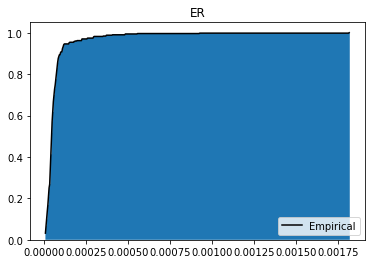

curve_fit parameter values:  [4.51953078 0.82438936]
curve_fit parameter values:  [4.51952863 0.41219492]
curve_fit parameter values:  [0.69102549 0.24087834]
curve_fit parameter values:  [0.62923474 0.10135211]
curve_fit parameter values:  [0.61112498 0.10925362]
curve_fit parameter values:  [4.74320923 0.45346804]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


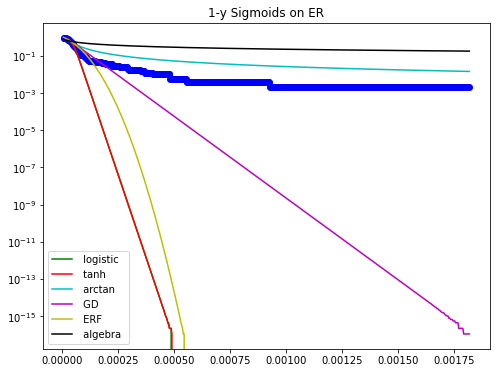

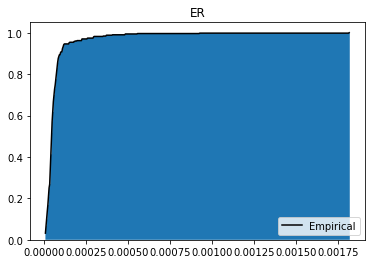

curve_fit parameter values:  [4.51953078 0.82438936]
curve_fit parameter values:  [4.51952863 0.41219492]
curve_fit parameter values:  [0.69102549 0.24087834]
curve_fit parameter values:  [0.62923474 0.10135211]
curve_fit parameter values:  [0.61112498 0.10925362]
curve_fit parameter values:  [4.74320923 0.45346804]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


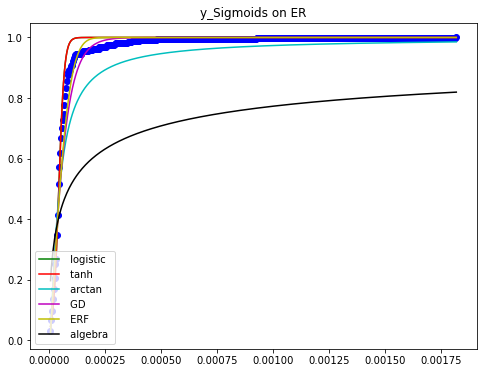

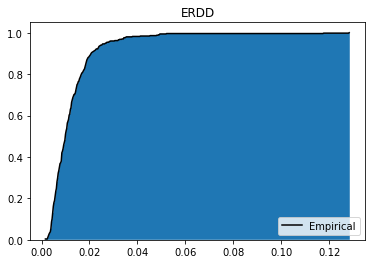

curve_fit parameter values:  [0.91525059 7.21990862]
curve_fit parameter values:  [0.91524698 3.60997285]
curve_fit parameter values:  [0.1911103  0.54024716]
curve_fit parameter values:  [0.19015267 0.25452071]
curve_fit parameter values:  [0.18980365 0.28126157]
curve_fit parameter values:  [1.01217827 0.20473379]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


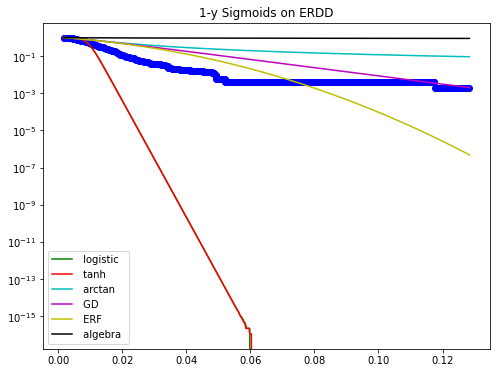

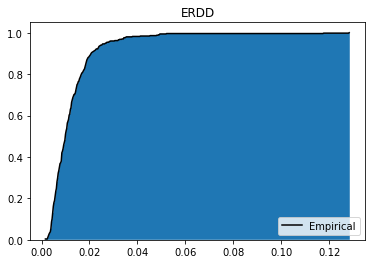

curve_fit parameter values:  [0.91525059 7.21990862]
curve_fit parameter values:  [0.91524698 3.60997285]
curve_fit parameter values:  [0.1911103  0.54024716]
curve_fit parameter values:  [0.19015267 0.25452071]
curve_fit parameter values:  [0.18980365 0.28126157]
curve_fit parameter values:  [1.01217827 0.20473379]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


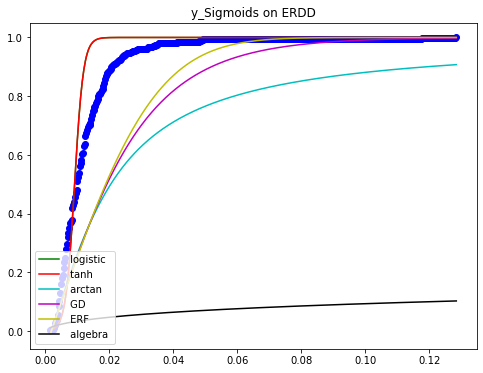

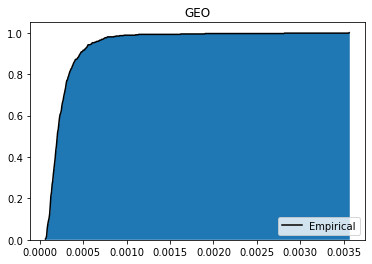

curve_fit parameter values:  [1.92774763 3.86156076]
curve_fit parameter values:  [1.92774496 1.93078549]
curve_fit parameter values:  [0.66289502 0.50306608]
curve_fit parameter values:  [0.66074458 0.22680531]
curve_fit parameter values:  [0.66006196 0.24814465]
curve_fit parameter values:  [2.07712928 0.20314146]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


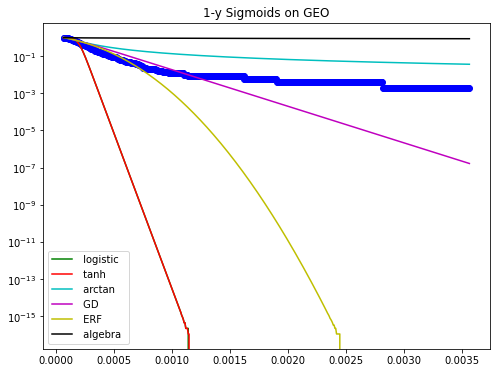

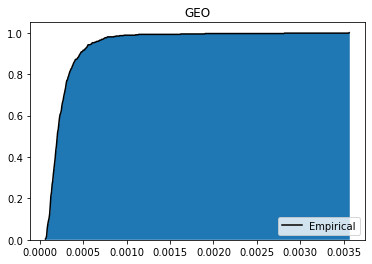

curve_fit parameter values:  [1.92774763 3.86156076]
curve_fit parameter values:  [1.92774496 1.93078549]
curve_fit parameter values:  [0.66289502 0.50306608]
curve_fit parameter values:  [0.66074458 0.22680531]
curve_fit parameter values:  [0.66006196 0.24814465]
curve_fit parameter values:  [2.07712928 0.20314146]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


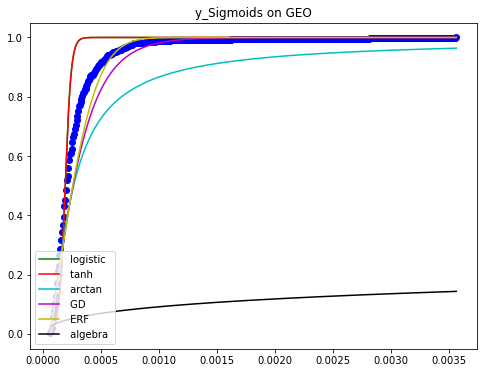

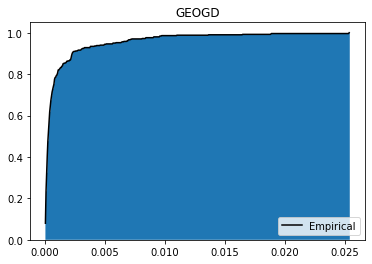

curve_fit parameter values:  [0.3883875  6.36909317]
curve_fit parameter values:  [0.38838893 3.18452871]
curve_fit parameter values:  [0.03697566 3.51984779]
curve_fit parameter values:  [0.01252291 1.20991988]
curve_fit parameter values:  [0.00634023 1.26356544]
curve_fit parameter values:  [0.35420422 2.3204201 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


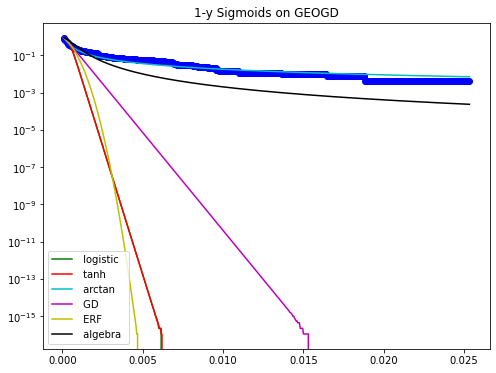

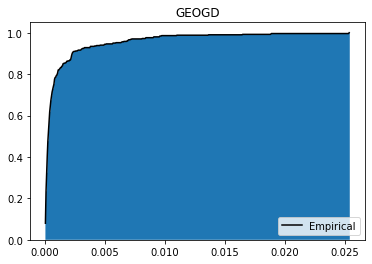

curve_fit parameter values:  [0.3883875  6.36909317]
curve_fit parameter values:  [0.38838893 3.18452871]
curve_fit parameter values:  [0.03697566 3.51984779]
curve_fit parameter values:  [0.01252291 1.20991988]
curve_fit parameter values:  [0.00634023 1.26356544]
curve_fit parameter values:  [0.35420422 2.3204201 ]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


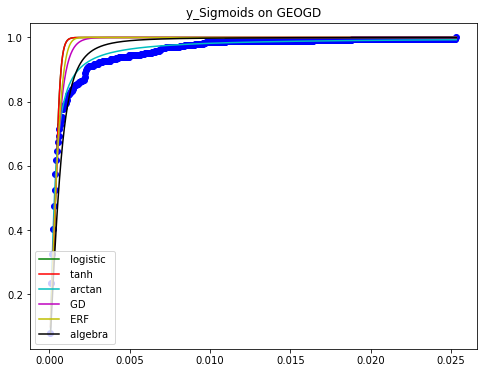

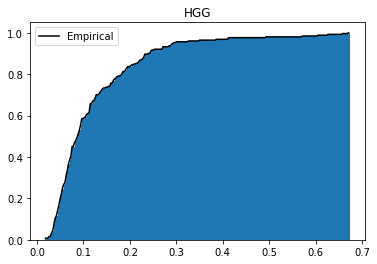

curve_fit parameter values:  [8.31967744 0.71512279]
curve_fit parameter values:  [8.31959073 0.35756673]
curve_fit parameter values:  [2.00083144 0.08326023]
curve_fit parameter values:  [1.9850286  0.03877571]
curve_fit parameter values:  [1.9779164 0.042448 ]
curve_fit parameter values:  [8.94144704 0.16784947]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


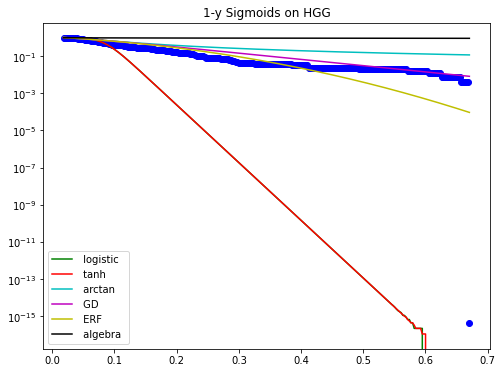

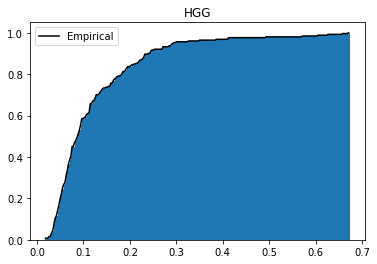

curve_fit parameter values:  [8.31967744 0.71512279]
curve_fit parameter values:  [8.31959073 0.35756673]
curve_fit parameter values:  [2.00083144 0.08326023]
curve_fit parameter values:  [1.9850286  0.03877571]
curve_fit parameter values:  [1.9779164 0.042448 ]
curve_fit parameter values:  [8.94144704 0.16784947]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


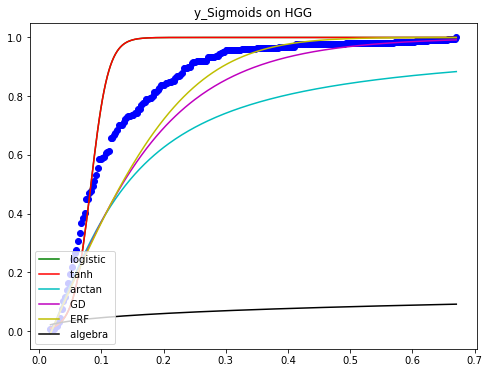

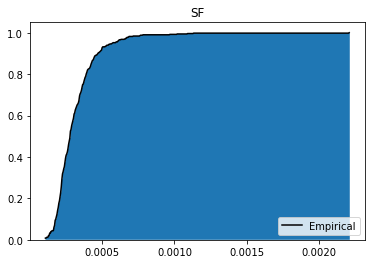

curve_fit parameter values:  [2.70904861 2.80140464]
curve_fit parameter values:  [2.70904343 1.4007076 ]
curve_fit parameter values:  [1.13342952 0.32103115]
curve_fit parameter values:  [1.1289473  0.15093577]
curve_fit parameter values:  [1.12726226 0.16659944]
curve_fit parameter values:  [2.82972287 0.19770122]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


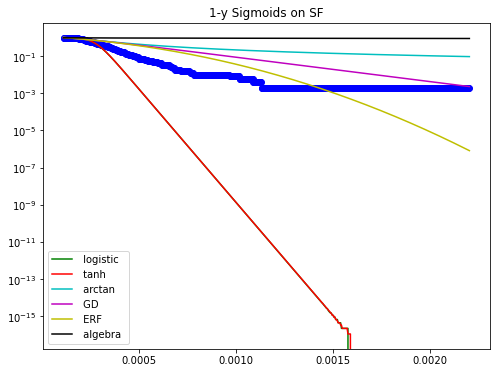

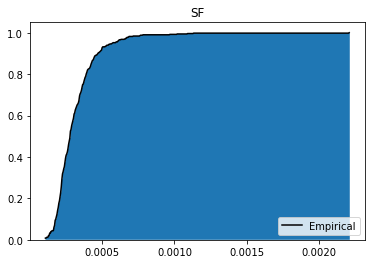

curve_fit parameter values:  [2.70904861 2.80140464]
curve_fit parameter values:  [2.70904343 1.4007076 ]
curve_fit parameter values:  [1.13342952 0.32103115]
curve_fit parameter values:  [1.1289473  0.15093577]
curve_fit parameter values:  [1.12726226 0.16659944]
curve_fit parameter values:  [2.82972287 0.19770122]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


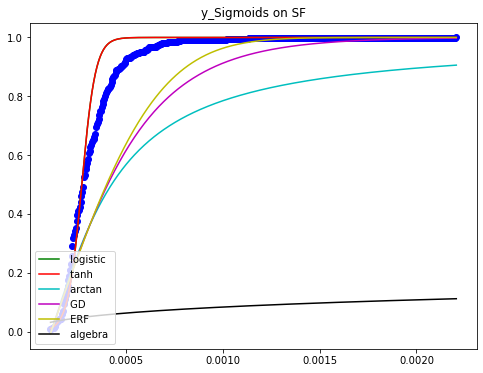

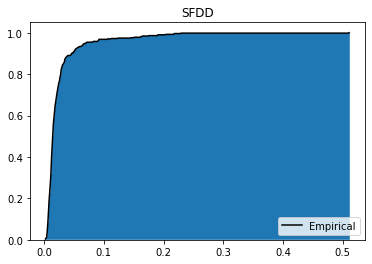

curve_fit parameter values:  [1.36406246 4.55149761]
curve_fit parameter values:  [1.36405518 2.27576467]
curve_fit parameter values:  [0.23615806 0.3252526 ]
curve_fit parameter values:  [0.23326251 0.14867519]
curve_fit parameter values:  [0.23252878 0.16417691]
curve_fit parameter values:  [1.55198565 0.26114068]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


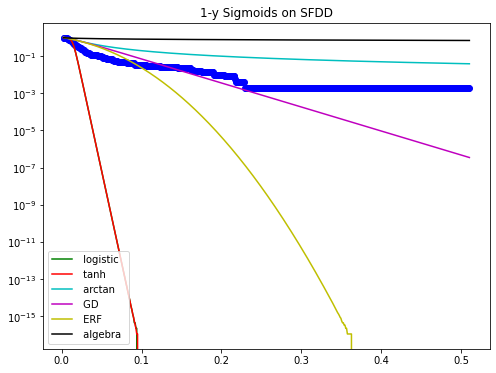

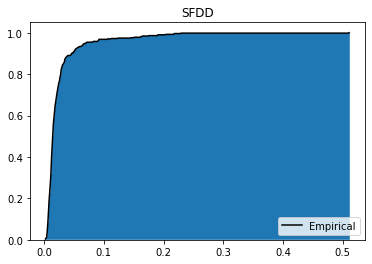

curve_fit parameter values:  [1.36406246 4.55149761]
curve_fit parameter values:  [1.36405518 2.27576467]
curve_fit parameter values:  [0.23615806 0.3252526 ]
curve_fit parameter values:  [0.23326251 0.14867519]
curve_fit parameter values:  [0.23252878 0.16417691]
curve_fit parameter values:  [1.55198565 0.26114068]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


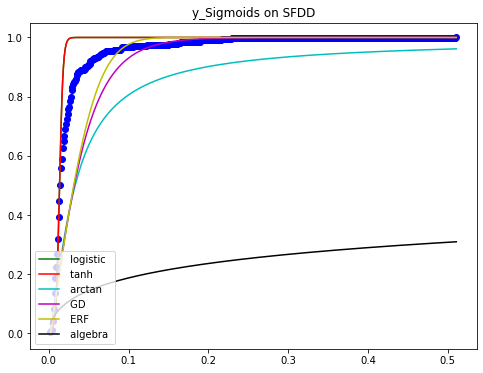

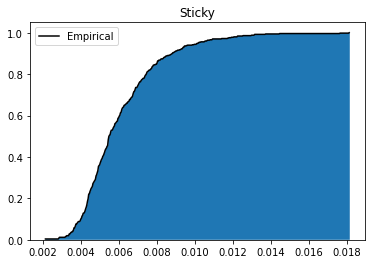

curve_fit parameter values:  [5.36043424 1.90066386]
curve_fit parameter values:  [5.36044675 0.95032714]
curve_fit parameter values:  [2.35094238 0.05094383]
curve_fit parameter values:  [2.35650895 0.02643797]
curve_fit parameter values:  [2.35882329 0.03030973]
curve_fit parameter values:  [5.49479545 0.12327566]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


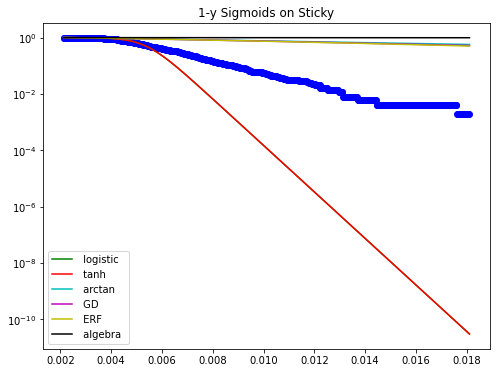

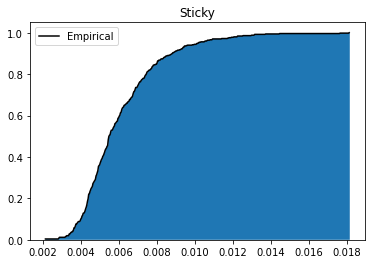

curve_fit parameter values:  [5.36043424 1.90066386]
curve_fit parameter values:  [5.36044675 0.95032714]
curve_fit parameter values:  [2.35094238 0.05094383]
curve_fit parameter values:  [2.35650895 0.02643797]
curve_fit parameter values:  [2.35882329 0.03030973]
curve_fit parameter values:  [5.49479545 0.12327566]


D:\anaconda\anaconda\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


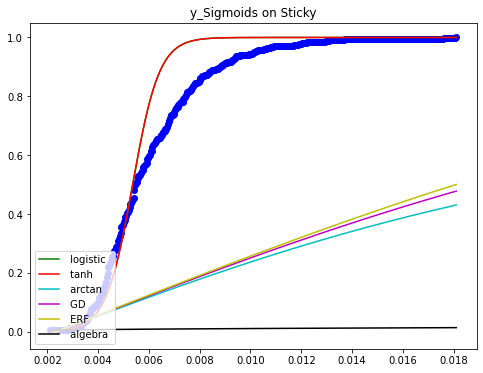

In [61]:
for i in range(len(classes[:-1])):
    data_i = data_distance(data(df_comb,classes[:-1][i]))
    sigmoids_for_data_1y(data_i, classes[:-1][i], factors[i], functions, colors)
    sigmoids_for_data_y(data_i, classes[:-1][i], factors[i], functions, colors)